In [1]:
import numpy as np
import pandas as pd

import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore') 
#warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier

import eli5
from eli5.sklearn import PermutationImportance

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv('Gold1.csv')

df = df.sort_values(by = 'datetime')
df['datetime'] = pd.to_datetime(df['datetime'], format="%Y/%m/%d")

df.index = df['datetime']

df = df.drop('datetime', axis = 1)

df = df['Gold_Price']



df.columns = ['Gold_Price']

df = pd.DataFrame(df)

df

,Gold_Price
datetime,
1990-01-02,399.60
1990-01-03,394.00
1990-01-04,398.60
1990-01-05,406.30
1990-01-08,403.00
...,...
2021-04-21,1792.30
2021-04-22,1781.20
2021-04-23,1777.00


In [3]:
# 데이터 나눈다.
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size = 0.8, shuffle=False)

In [4]:
# 데이터를 0~1의 데이터로 사이즈를 축소
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train)
train_trans = scaler.transform(train)
test_trans = scaler.transform(test)

In [5]:
pd.DataFrame(train_trans, index=train.index, columns=train.columns)

,Gold_Price
datetime,
1990-01-02,0.089625
1990-01-03,0.086202
1990-01-04,0.089014
1990-01-05,0.093721
1990-01-08,0.091704
...,...
2015-04-09,0.628844
2015-04-10,0.635997
2015-04-13,0.632634


In [6]:
def step_split(sequence, n_steps, n_features, n_predict_steps, test_set=False):
  sequence = np.array(sequence).reshape(-1, n_features)
  X, y = list(), list()
  if test_set:
    start_n = len(sequence) % n_steps 
    finish_n = len(sequence) - n_steps + 1
    for i in range(start_n, finish_n):
      seq_x = sequence[i:i+n_steps]
      X.append(seq_x)
    X = np.array(X)
    X = X.reshape(X.shape[0], n_steps, n_features)
  else:  
    start_n = (len(sequence) + n_predict_steps) % n_steps 
    finish_n = len(sequence) - n_predict_steps - n_steps + 1
    for i in range(start_n, finish_n):
      seq_x, seq_y = sequence[i:i+n_steps], sequence[i+n_steps:i+n_steps+n_predict_steps][:,0]
      
      X.append(seq_x)
      y.append(seq_y)
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], n_steps, n_features)
    y = y.reshape(y.shape[0], n_predict_steps)

  return X, y

In [7]:
# 3개의 파라미터가 있는데 여기서 n_steps는 20일을 기준으로 다음 데이터를 예측한다는 것이고
# n_features는 설명 변수를 나타낸다.
# n_predict_steps가 1이면 1일을 예측하는것, n이면 n일을 예측
# reshape()의 '-1'이 의미하는 바는, 변경된 배열의 '-1' 위치의 차원은 "원래 배열의 길이와 남은 차원으로 부터 추정"이 된다는 뜻


n_steps = 20
n_features = 1
n_predict_steps = 1


x_train, y_train = step_split(train_trans, n_steps,n_features, n_predict_steps)
x_test, y_test = step_split(test_trans, n_steps,n_features, n_predict_steps)

In [8]:
# 최종 학습 데이터, 하나의 열이 하나의 input 데이터다.
pd.DataFrame(x_train.reshape(x_train.shape[1],x_train.shape[0]),
             index = [f'day{x+1}' for x in range(x_train.shape[1])],
             columns = [f'input_{x+1}' for x in range(x_train.shape[0])])

,input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8,input_9,input_10,...,input_6330,input_6331,input_6332,input_6333,input_6334,input_6335,input_6336,input_6337,input_6338,input_6339
day1,0.100385,0.099652,0.102158,0.101547,0.100935,0.097451,0.100874,0.100997,0.103564,0.102892,...,0.064254,0.063642,0.064560,0.065477,0.065354,0.062970,0.062481,0.063826,0.063704,0.063153
day2,0.062481,0.060586,0.062909,0.062970,0.062359,0.061686,0.062603,0.063276,0.063642,0.064254,...,0.059546,0.057651,0.052332,0.049581,0.050009,0.051293,0.050621,0.051904,0.051599,0.051538
day3,0.054166,0.053555,0.063276,0.063826,0.060891,0.060952,0.058813,0.058690,0.059485,0.059546,...,0.069817,0.072568,0.075870,0.074464,0.075197,0.075686,0.075075,0.073424,0.074708,0.074036
day4,0.075686,0.075442,0.076420,0.071040,0.071223,0.070979,0.070734,0.066149,0.067066,0.069817,...,0.074769,0.075381,0.075686,0.075442,0.075136,0.075442,0.075564,0.075564,0.076787,0.076787
day5,0.077581,0.077337,0.075686,0.075564,0.074830,0.075625,0.075870,0.075686,0.075381,0.074769,...,0.086263,0.086324,0.085835,0.085713,0.084245,0.084673,0.084796,0.085346,0.085346,0.085101
day6,0.084123,0.084184,0.084673,0.084612,0.084123,0.084918,0.085774,0.086263,0.085285,0.086263,...,0.041878,0.044690,0.045974,0.045057,0.045118,0.043529,0.044446,0.041634,0.042795,0.041756
day7,0.042917,0.044751,0.043773,0.044446,0.044324,0.043468,0.043345,0.041206,0.039861,0.041878,...,0.024332,0.024821,0.024515,0.026839,0.026288,0.025738,0.025371,0.027389,0.026166,0.026411
day8,0.026900,0.026533,0.026594,0.024149,0.024699,0.024271,0.023415,0.025066,0.024577,0.024332,...,0.030262,0.029590,0.031913,0.032157,0.028978,0.028184,0.024454,0.024149,0.024088,0.023537
day9,0.021520,0.021887,0.021336,0.023965,0.021948,0.023354,0.021764,0.022681,0.029773,0.030262,...,0.019625,0.018708,0.015956,0.015223,0.012716,0.007764,0.007520,0.008192,0.007764,0.007764
day10,0.007948,0.012472,0.009109,0.011310,0.011616,0.013633,0.011127,0.011860,0.012472,0.019625,...,0.036926,0.037843,0.039861,0.040900,0.041756,0.039677,0.038882,0.040289,0.038882,0.039188


In [9]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [10]:
# 16층 LSTM, 마지막의 1가지 숫자를 예측

Epoch 1 / 11
6339/6339 [==============================] - 19s 3ms/step - loss: 1.4732e-04 - val_loss: 0.0130


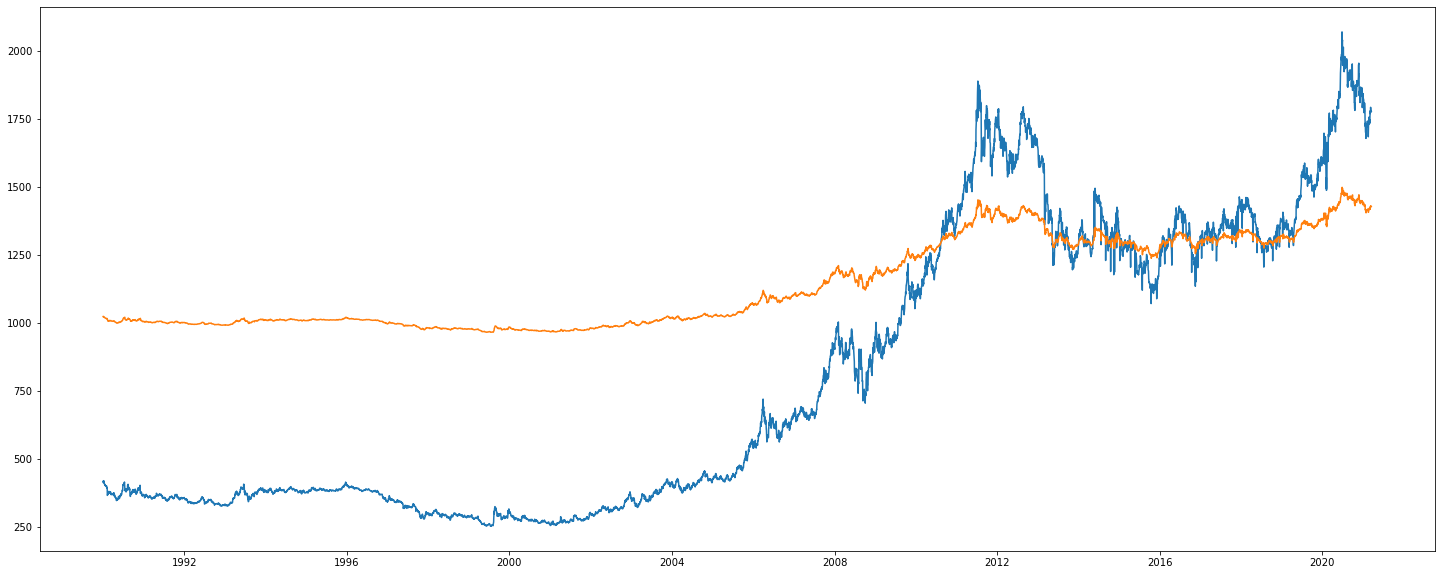

Epoch 2 / 11
6339/6339 [==============================] - 18s 3ms/step - loss: 2.7195e-04 - val_loss: 0.0107
Epoch 3 / 11
6339/6339 [==============================] - 19s 3ms/step - loss: 2.4047e-04 - val_loss: 0.0082
Epoch 4 / 11
6339/6339 [==============================] - 19s 3ms/step - loss: 1.7872e-04 - val_loss: 0.0073
Epoch 5 / 11
6339/6339 [==============================] - 18s 3ms/step - loss: 1.5949e-04 - val_loss: 0.0077
Epoch 6 / 11
6339/6339 [==============================] - 18s 3ms/step - loss: 1.4428e-04 - val_loss: 0.0082


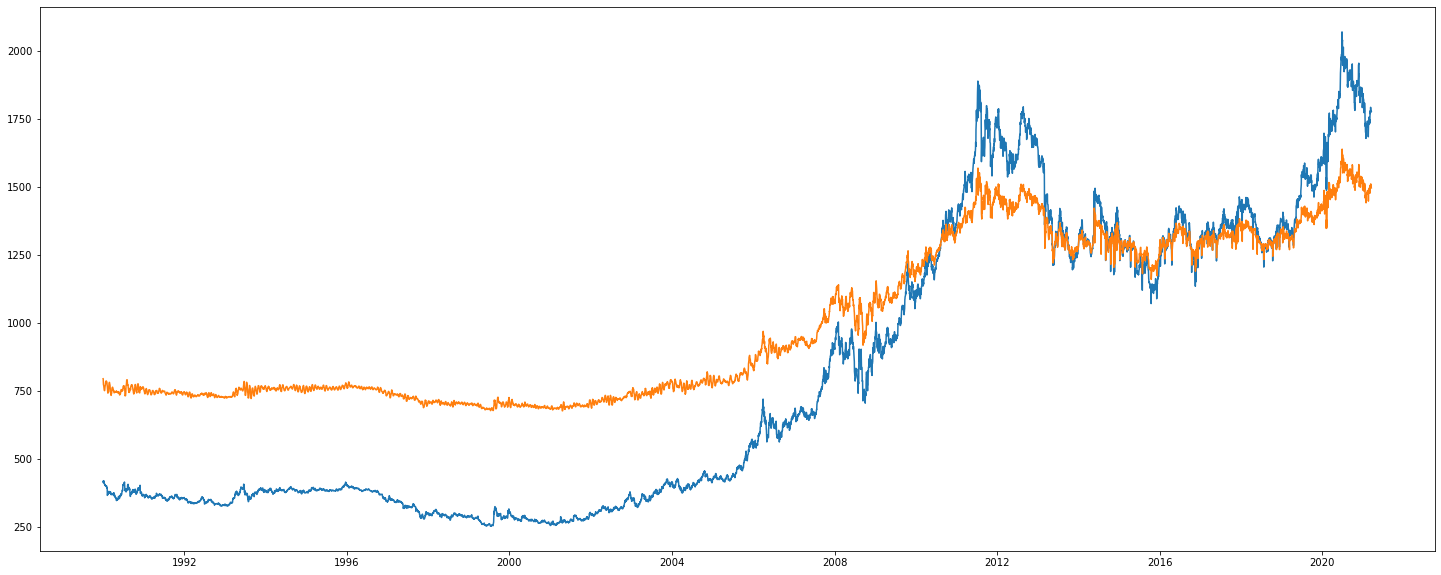

Epoch 7 / 11
6339/6339 [==============================] - 18s 3ms/step - loss: 1.3473e-04 - val_loss: 0.0063
Epoch 8 / 11
6339/6339 [==============================] - 18s 3ms/step - loss: 1.1651e-04 - val_loss: 0.0066
Epoch 9 / 11
6339/6339 [==============================] - 18s 3ms/step - loss: 1.1955e-04 - val_loss: 0.0065
Epoch 10 / 11
6339/6339 [==============================] - 18s 3ms/step - loss: 9.5899e-05 - val_loss: 0.0070
Epoch 11 / 11
6339/6339 [==============================] - 18s 3ms/step - loss: 9.0462e-05 - val_loss: 0.0076


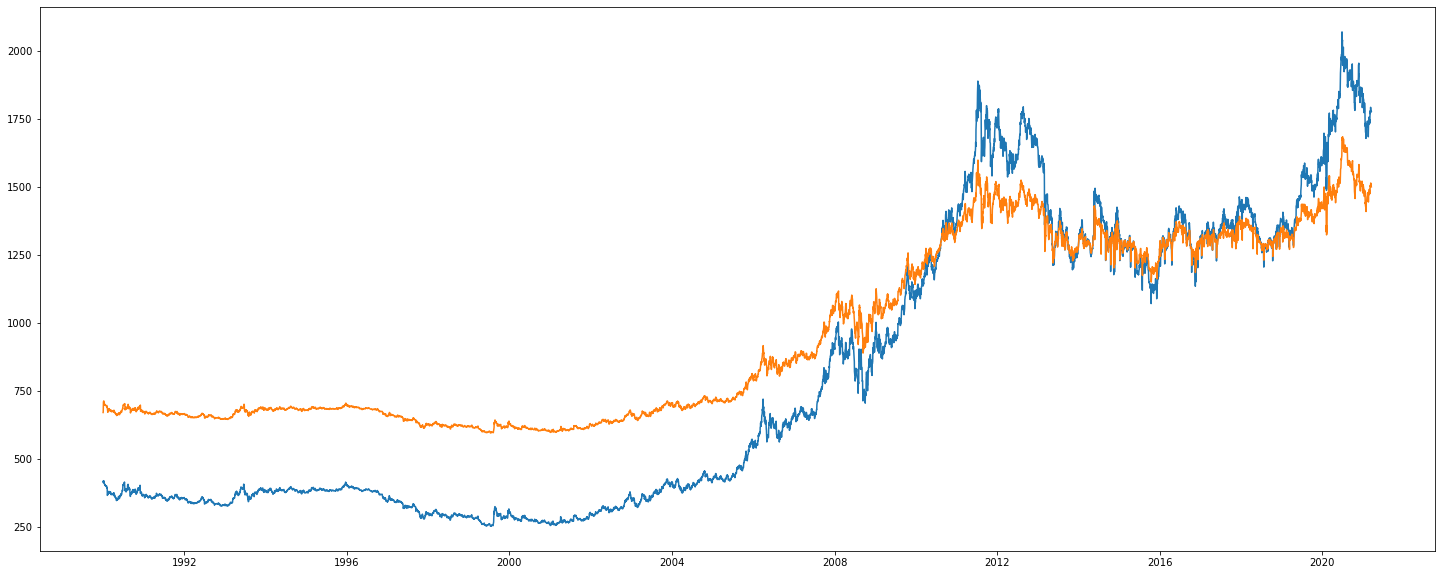

In [11]:
def create_model(stateful,batch_size, n_steps, n_features):
    model = Sequential()
    model.add(LSTM(16,
                   batch_input_shape=(batch_size, n_steps, n_features),
                   stateful=stateful
                   ))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

batch_size = 1
epochs = 11

x, y = step_split(scaler.transform(df), n_steps, n_features, n_predict_steps)
y = scaler.inverse_transform(y)


model_stateful = create_model(True, batch_size, n_steps, n_features)

for i in range(epochs): 
    print('Epoch', i + 1, '/', epochs)
    model_stateful.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=1,
                      verbose=1,
                      shuffle=False,
                      validation_data=(x_test, y_test)
                       )
    if i % 5 == 0:
      y_hat = model_stateful.predict(x, batch_size=batch_size)
      y_hat = scaler.inverse_transform(y_hat)

      plt.figure(figsize=(25, 10))
      plt.plot(df.index[:len(y_hat)],y[:len(y_hat)])
      plt.plot(df.index[:len(y_hat)],y_hat)
      plt.show()

In [12]:
len(y)

7939

In [13]:
len(y_hat)

7939

In [14]:
df  = pd.DataFrame([df.index[:len(y_hat)],y[:len(y_hat)]])
df2 = pd.DataFrame([df.index[:len(y_hat)],y_hat])

In [15]:
df = df.T
df2 = df2.T

In [16]:
df.columns = ['datetime','Gold_Price']
df2.columns = ['datetime','Gold_Price']

In [17]:
ans = df[7620:]['Gold_Price']
ans

7620                [1591.1]
7621                [1592.4]
7622                [1599.6]
7623                [1606.9]
7624               [1586.25]
                ...         
7934                [1792.3]
7935                [1781.2]
7936                [1777.0]
7937               [1774.65]
7938    [1776.7999999999997]
Name: Gold_Price, Length: 319, dtype: object

In [18]:
pred = df2[7620:]['Gold_Price']
type(pred)

pandas.core.series.Series

In [21]:
#ans = ans.values.tolist()
#type(ans[0])

In [22]:
ans = ans.tolist()
pred= pred.tolist()

In [29]:
y_test=[]
for i in range(len(ans)):
    y_test.append(ans[i].tolist())

y_pred_test=[]
for i in range(len(ans)):
    y_pred_test.append(pred[i].tolist())

In [35]:
y_test = sum(y_test, [])
y_pred_test = sum(y_pred_test, [])

In [34]:
y_test

[1591.1,
 1592.4,
 1599.6,
 1606.9,
 1586.25,
 1587.05,
 1624.0,
 1632.2,
 1640.8,
 1669.1,
 1697.0999999999997,
 1670.2,
 1662.9,
 1661.4,
 1583.6,
 1609.7,
 1658.8,
 1656.5,
 1680.3999999999999,
 1683.0,
 1684.1,
 1668.9999999999998,
 1650.8000000000002,
 1598.8,
 1524.9,
 1493.8,
 1534.1,
 1487.1,
 1489.4,
 1495.1,
 1581.4,
 1663.0,
 1633.3,
 1662.0,
 1655.0,
 1644.1,
 1597.6,
 1592.5,
 1638.9,
 1646.5,
 1693.1000000000001,
 1683.7000000000003,
 1684.1,
 1753.6000000000001,
 1740.6,
 1762.7,
 1771.1999999999998,
 1744.7000000000003,
 1736.3,
 1702.7,
 1715.3,
 1692.0999999999997,
 1743.5,
 1751.0,
 1741.7,
 1731.4,
 1731.2,
 1722.4,
 1704.9,
 1712.0,
 1725.9,
 1728.0,
 1704.4,
 1743.6999999999998,
 1735.2,
 1720.9,
 1728.0,
 1737.3,
 1762.0,
 1778.7,
 1760.6,
 1773.4,
 1781.7,
 1750.4,
 1765.6,
 1730.65,
 1727.0,
 1740.5,
 1740.5,
 1742.7,
 1765.6999999999998,
 1763.7,
 1749.6999999999998,
 1723.5,
 1746.3999999999999,
 1701.8999999999999,
 1723.8,
 1740.3,
 1739.0,
 1757.5999999999

In [40]:
y_pred_test

[1432.4267578125,
 1424.8521728515625,
 1425.99755859375,
 1430.310791015625,
 1435.282958984375,
 1420.1497802734375,
 1421.8739013671875,
 1447.8563232421875,
 1452.415771484375,
 1460.082275390625,
 1480.4215087890625,
 1499.501953125,
 1479.651123046875,
 1475.8109130859375,
 1472.45556640625,
 1415.11083984375,
 1433.568359375,
 1462.031494140625,
 1457.6875,
 1475.1419677734375,
 1474.574951171875,
 1475.1268310546875,
 1463.181396484375,
 1449.6650390625,
 1411.460205078125,
 1358.1263427734375,
 1333.7191162109375,
 1359.403564453125,
 1323.380126953125,
 1329.8123779296875,
 1334.873779296875,
 1402.5330810546875,
 1464.0311279296875,
 1447.5157470703125,
 1478.4322509765625,
 1474.0067138671875,
 1470.5286865234375,
 1438.593017578125,
 1437.1712646484375,
 1468.6236572265625,
 1470.9676513671875,
 1504.3564453125,
 1493.897705078125,
 1494.0418701171875,
 1539.654541015625,
 1524.3079833984375,
 1539.4832763671875,
 1540.2015380859375,
 1518.6170654296875,
 1509.743774414062

In [43]:
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(y_test, y_pred_test)**0.5
print(RMSE)

293.86689618096153


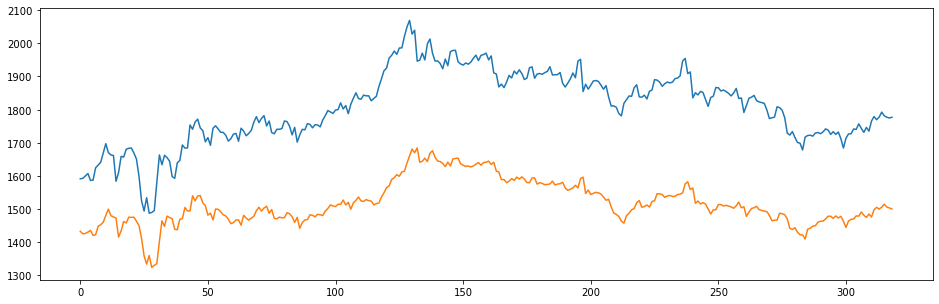

In [46]:
# 파란색이 현재 이후 예측 값 2022 4월 까지 그림

fig, ax = plt.subplots(figsize=(16,5))
plt.plot(y_test)
plt.plot(y_pred_test)
plt.show()

In [47]:
from sklearn.metrics import r2_score
print(r2_score(y_test,y_pred_test))

-6.099073536635048
